# 🚢 Titanic Survival Analysis

This notebook presents a comprehensive analysis of Titanic passenger survival data.  
Includes:  
- Data exploration and visualization  
- Feature engineering, including missing value imputation and new feature creation  
- Training an XGBoost classification model  
- Model evaluation using classification metrics and confusion matrix visualization  
- Feature importance analysis for model interpretability  

The goal is to build an accurate and interpretable classifier to understand key factors influencing survival.

In [546]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from colorama import Fore, Style
from numpy.typing import NDArray
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    mean_absolute_error,
    mean_squared_error,
    precision_score,
    r2_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

## 🛠️ Utility Functions

In [547]:
def evaluate_regression(
    y_true: NDArray[np.float64], y_pred: NDArray[np.float64]
) -> dict[str, float]:
    """Compute and print regression evaluation metrics.

    Args:
        y_true (NDArray[np.float64]): True target values.
        y_pred (NDArray[np.float64]): Predicted target values.

    Returns:
        dict[str, float]: MAE, MSE, and R² score.
    """
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"{Fore.CYAN}Mean Absolute Error (MAE):{Style.RESET_ALL} {mae:.4f}")
    print(f"{Fore.CYAN}Mean Squared Error (MSE):{Style.RESET_ALL} {mse:.4f}")
    print(f"{Fore.CYAN}R² Score:{Style.RESET_ALL} {r2:.4f}")

    return {"mae": mae, "mse": mse, "r2": r2}


def evaluate_classification(
    y_true: NDArray[np.int64], y_pred: NDArray[np.int64]
) -> dict[str, float]:
    """Print and return classification metrics.

    Args:
        y_true (NDArray[np.int64]): Ground truth labels.
        y_pred (NDArray[np.int64]): Predicted labels.

    Returns:
        dict[str, float]: Dictionary with accuracy, precision, recall, and F1-score.
    """
    accuracy: float = accuracy_score(y_true, y_pred)
    precision: float = precision_score(
        y_true, y_pred, average="weighted", zero_division=0
    )
    recall: float = recall_score(y_true, y_pred, average="weighted", zero_division=0)
    f1: float = f1_score(y_true, y_pred, average="weighted", zero_division=0)

    print(f"{Fore.CYAN}Accuracy:  {Style.RESET_ALL}{accuracy:.6f}")
    print(f"{Fore.CYAN}Precision: {Style.RESET_ALL}{precision:.6f}")
    print(f"{Fore.CYAN}Recall:    {Style.RESET_ALL}{recall:.6f}")
    print(f"{Fore.CYAN}F1 Score:  {Style.RESET_ALL}{f1:.6f}")

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [548]:
def plot_confusion_matrix(y_true: NDArray[np.int64], y_pred: NDArray[np.int64]) -> None:
    """Display a confusion matrix using seaborn heatmap.

    Args:
        y_true (NDArray[np.int64]): True labels.
        y_pred (NDArray[np.int64]): Predicted labels.
    """
    conf_matrix = confusion_matrix(y_true, y_pred)

    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
    )
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

## 📥 Load and Inspect Titanic Dataset

In [549]:
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(url)

In [550]:
print(f"{Fore.CYAN + Style.BRIGHT}DataFrame Info:{Style.RESET_ALL}")
print(df.info())

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [551]:
print(f"{Fore.GREEN + Style.BRIGHT}DataFrame Description:{Style.RESET_ALL}")
print(df.describe(include="all"))

DataFrame Description:
        PassengerId    Survived      Pclass                     Name   Sex  \
count    891.000000  891.000000  891.000000                      891   891   
unique          NaN         NaN         NaN                      891     2   
top             NaN         NaN         NaN  Braund, Mr. Owen Harris  male   
freq            NaN         NaN         NaN                        1   577   
mean     446.000000    0.383838    2.308642                      NaN   NaN   
std      257.353842    0.486592    0.836071                      NaN   NaN   
min        1.000000    0.000000    1.000000                      NaN   NaN   
25%      223.500000    0.000000    2.000000                      NaN   NaN   
50%      446.000000    0.000000    3.000000                      NaN   NaN   
75%      668.500000    1.000000    3.000000                      NaN   NaN   
max      891.000000    1.000000    3.000000                      NaN   NaN   

               Age       SibSp       Par

In [552]:
print(f"{Fore.YELLOW + Style.BRIGHT}First Rows of DataFrame:{Style.RESET_ALL}")
print(df.head())

First Rows of DataFrame:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8

In [553]:
print(f"{Fore.RED + Style.BRIGHT}Missing Values in Each Column:{Style.RESET_ALL}")
print(df.isnull().sum())

Missing Values in Each Column:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


### 🧭 Feature Exploration & Selection

##### 💰 Socio-Economic Status Indicators  

These features may indicate a passenger's **wealth, class**, or **boarding conditions**, all of which are linked to survival priority:

- **`Pclass`**: Passenger class (1st, 2nd, 3rd) — higher-class passengers may have had priority in lifeboats.
- **`Name`**: Although not useful directly, it allows us to extract titles (e.g., "Mr", "Miss", "Dr"), which indicate **social role or marital status**.
- **`Fare`**: Ticket price, likely correlated with wealth.
- **`Embarked`**: Port of embarkation — may reflect class or travel route patterns.

##### 👨‍👩‍👧‍👦 Family & Social Dynamics  

These features describe relationships, which could influence **protective behavior or group dynamics** during evacuation:

- **`Sex`**: Gender played a significant role in survival rates due to the “women and children first” policy.
- **`SibSp`** and **`Parch`**: Number of siblings/spouses and parents/children aboard.
- **`Age`**: Children may have been prioritized; age also influences strength and independence.

##### 🎫 Group Travel Indicators  

- **`Ticket`**: Passengers with the same ticket number likely traveled together. Group size can be extracted and used to determine if a passenger had friends or group affiliation, which might affect survival.

##### 🚫 Feature to Drop or Handle with Care  

- **`Cabin`**: This feature has over **77% missing values**, making it unreliable. Although cabin information might relate to deck and survival access, the sparsity outweighs potential benefits unless domain-specific imputation is applied.

##### ✅ Summary

From these insights, we engineer several useful features like:
- `Title` (from Name)
- `RelativesOnBoard`, `WithFamily`, `WithFriends`, `TrulyAlone` (from SibSp, Parch, and Ticket)
- Encoded `Sex` and `Embarked`

## 🧹 Feature Engineering

In [554]:
def preprocess(df: pd.DataFrame, ticket_counts: pd.Series = None) -> pd.DataFrame:
    """Preprocess the Titanic dataset.

    Steps performed:
    - Encode 'Sex' as binary (1 = male, 0 = female).
    - Fill missing values in 'Embarked' with the mode.
    - Extract and normalize titles from passenger names.
    - Create 'RelativesOnBoard' from 'SibSp' + 'Parch'.
    - Create 'WithFamily', 'WithFriends', and 'TrulyAlone' binary features.
    - Map ticket counts to identify passengers sharing a ticket.
    - Encode 'Title' and 'Embarked' with LabelEncoder.

    Args:
        df (pd.DataFrame): Input DataFrame containing Titanic data.
        ticket_counts (pd.Series, optional): Precomputed ticket frequency mapping.
            If not provided, it will be computed from `df`.

    Returns:
        pd.DataFrame: A preprocessed copy of the input DataFrame with new and
            encoded features.
    """
    df = df.copy()
    df["Sex"] = (df["Sex"] == "male").astype(int)
    df.fillna({"Embarked": df["Embarked"].mode()[0]}, inplace=True)

    # Title extraction and normalization
    df["Title"] = df["Name"].str.extract(r",\s*([^\.]*)\s*\.", expand=False)
    df["Title"] = df["Title"].replace(
        {
            "Mlle": "Miss",
            "Ms": "Miss",
            "Mme": "Mrs",
            "Lady": "Rare",
            "Countess": "Rare",
            "Capt": "Rare",
            "Col": "Rare",
            "Don": "Rare",
            "Dr": "Rare",
            "Major": "Rare",
            "Rev": "Rare",
            "Sir": "Rare",
            "Jonkheer": "Rare",
            "Dona": "Rare",
            "the Countess": "Rare",
        }
    )

    df["RelativesOnBoard"] = df["SibSp"] + df["Parch"]
    df["WithFamily"] = (df["RelativesOnBoard"] > 0).astype(int)

    # Ticket-based features
    if ticket_counts is None:
        ticket_counts = df["Ticket"].value_counts()

    df["TicketCount"] = df["Ticket"].map(ticket_counts)
    df["WithFriends"] = (
        (df["RelativesOnBoard"] == 0) & (df["TicketCount"] > 1)
    ).astype(int)

    df["TrulyAlone"] = (
        (df["RelativesOnBoard"] == 0) & (df["TicketCount"] == 1)
    ).astype(int)

    # Encode categorical features
    le = LabelEncoder()
    df["Title"] = le.fit_transform(df["Title"])
    df["Embarked"] = le.fit_transform(df["Embarked"])

    return df


df = preprocess(df)

#### 🧠 Predicting Missing Age Values

In [555]:
df_age_model = df.copy()
df_age_model.loc[df["Age"].isnull(), "Age"] = None

features = [
    "Pclass",
    "Sex",
    "SibSp",
    "Parch",
    "RelativesOnBoard",
    "TicketCount",
    "WithFamily",
    "WithFriends",
    "TrulyAlone",
    "Embarked",
    "Title",
]
known_age = df_age_model[df_age_model["Age"].notnull()]
missing_age = df_age_model[df_age_model["Age"].isnull()]

X_age = known_age[features]
y_age = known_age["Age"]

X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(
    X_age, y_age, random_state=42
)

In [556]:
age_model = RandomForestRegressor(n_estimators=100, random_state=42)
age_model.fit(X_train_age, y_train_age)

y_pred_age = age_model.predict(X_test_age)

In [557]:
print(
    f"{Fore.MAGENTA + Style.BRIGHT}Random Forest Model Performance (Age Prediction):"
    f"{Style.RESET_ALL}"
)
_ = evaluate_regression(y_test_age, y_pred_age)

print(
    f"\n{Fore.MAGENTA + Style.BRIGHT}Baseline (Mean Age for All Samples):"
    f"{Style.RESET_ALL}"
)
_ = evaluate_regression(y_test_age, np.full_like(y_test_age, np.mean(y_age)))

Random Forest Model Performance (Age Prediction):
Mean Absolute Error (MAE): 8.0285
Mean Squared Error (MSE): 107.1817
R² Score: 0.3864

Baseline (Mean Age for All Samples):
Mean Absolute Error (MAE): 10.6155
Mean Squared Error (MSE): 176.6649
R² Score: -0.0114


Although the R² score (**~0.39**) is moderate, the **Random Forest model** significantly outperforms the **naive baseline**, enabling us to reliably impute missing age values and improve the quality of subsequent classification

In [558]:
predicted_ages = age_model.predict(missing_age[features])
df_age_model.loc[df_age_model["Age"].isnull(), "Age"] = predicted_ages

df = df_age_model

## 📊 Exploratory Data Visualizations

#### 🚢 General Survival Analysis

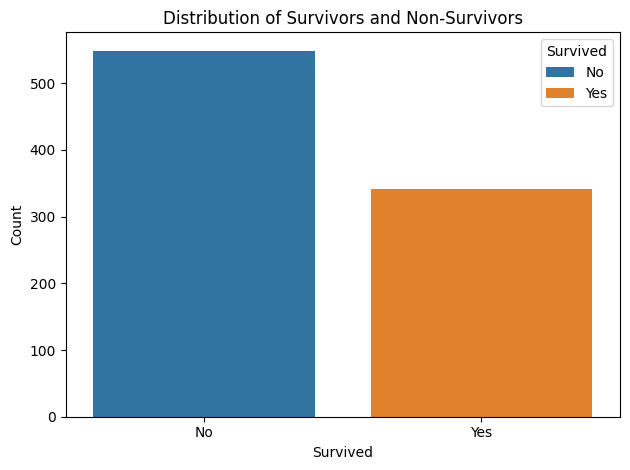

In [559]:
sns.countplot(x="Survived", data=df, hue="Survived")
plt.title("Distribution of Survivors and Non-Survivors")
plt.xlabel("Survived")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1], labels=["No", "Yes"])
plt.legend(title="Survived", labels=["No", "Yes"])
plt.tight_layout()
plt.show()

#### 💰 Wealth & Port of Embarkation vs Survival

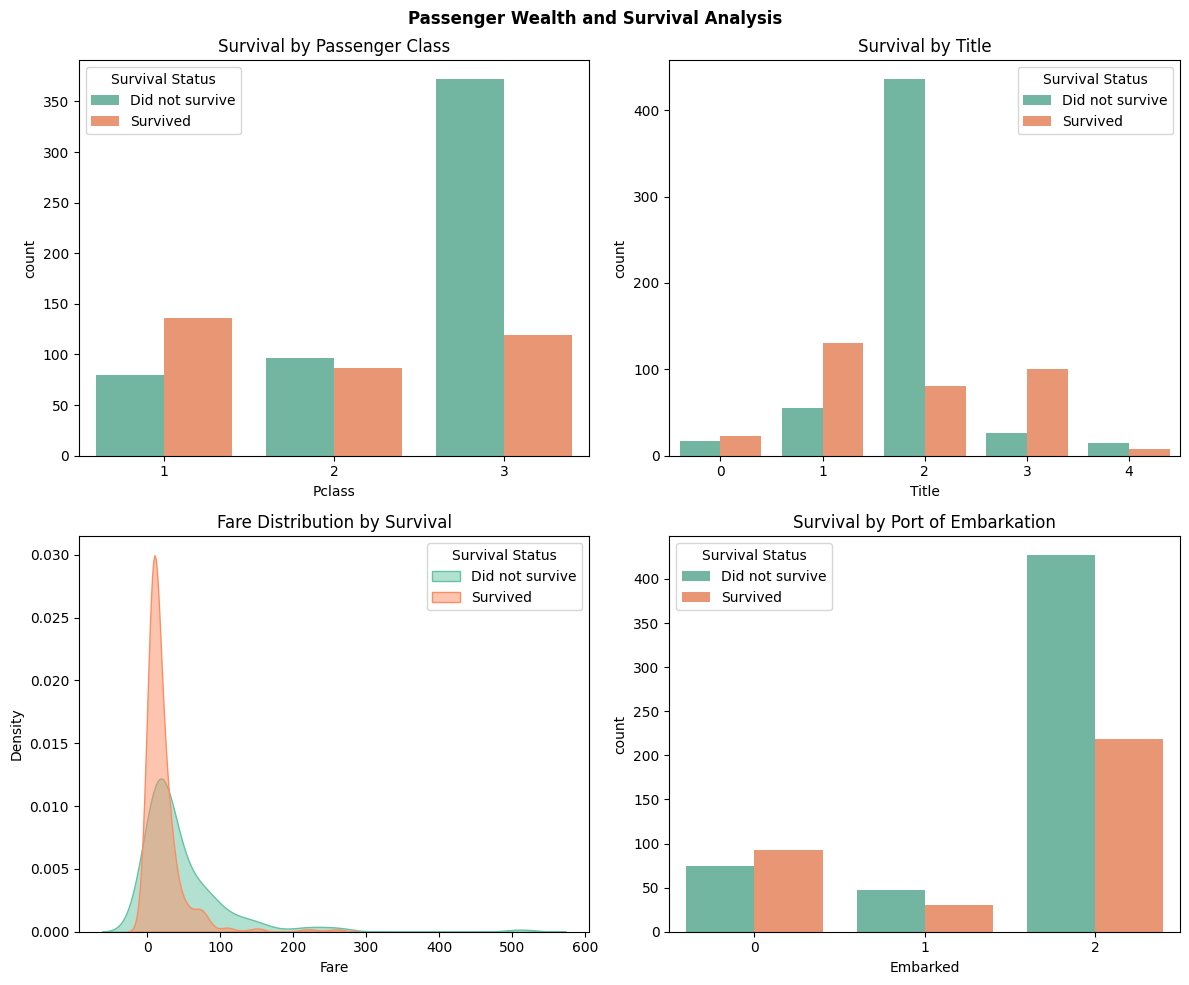

In [560]:
palette = "Set2"

fig = plt.figure(figsize=(12, 10))
fig.suptitle("Passenger Wealth and Survival Analysis", fontweight="bold")

ax1 = plt.subplot2grid((2, 2), (0, 0))
sns.countplot(x="Pclass", hue="Survived", data=df, ax=ax1, palette=palette)
ax1.set_title("Survival by Passenger Class")
ax1.legend(title="Survival Status", labels=["Did not survive", "Survived"])

ax2 = plt.subplot2grid((2, 2), (0, 1))
sns.countplot(x="Title", hue="Survived", data=df, ax=ax2, palette=palette)
ax2.set_title("Survival by Title")
ax2.legend(title="Survival Status", labels=["Did not survive", "Survived"])

ax3 = plt.subplot2grid((2, 2), (1, 0))
sns.kdeplot(
    df.loc[df["Survived"] == 1, "Fare"].dropna(),
    label=1,
    ax=ax3,
    color=sns.color_palette(palette)[0],
    fill=True,
    alpha=0.5,
)
sns.kdeplot(
    df.loc[df["Survived"] == 0, "Fare"].dropna(),
    label=0,
    ax=ax3,
    color=sns.color_palette(palette)[1],
    fill=True,
    alpha=0.5,
)
ax3.set_title("Fare Distribution by Survival")
ax3.legend(title="Survival Status", labels=["Did not survive", "Survived"])

ax4 = plt.subplot2grid((2, 2), (1, 1))
sns.countplot(x="Embarked", hue="Survived", data=df, ax=ax4, palette=palette)
ax4.set_title("Survival by Port of Embarkation")
ax4.legend(title="Survival Status", labels=["Did not survive", "Survived"])

plt.tight_layout()
plt.show()

#### 🧬 Demographics and Relationships

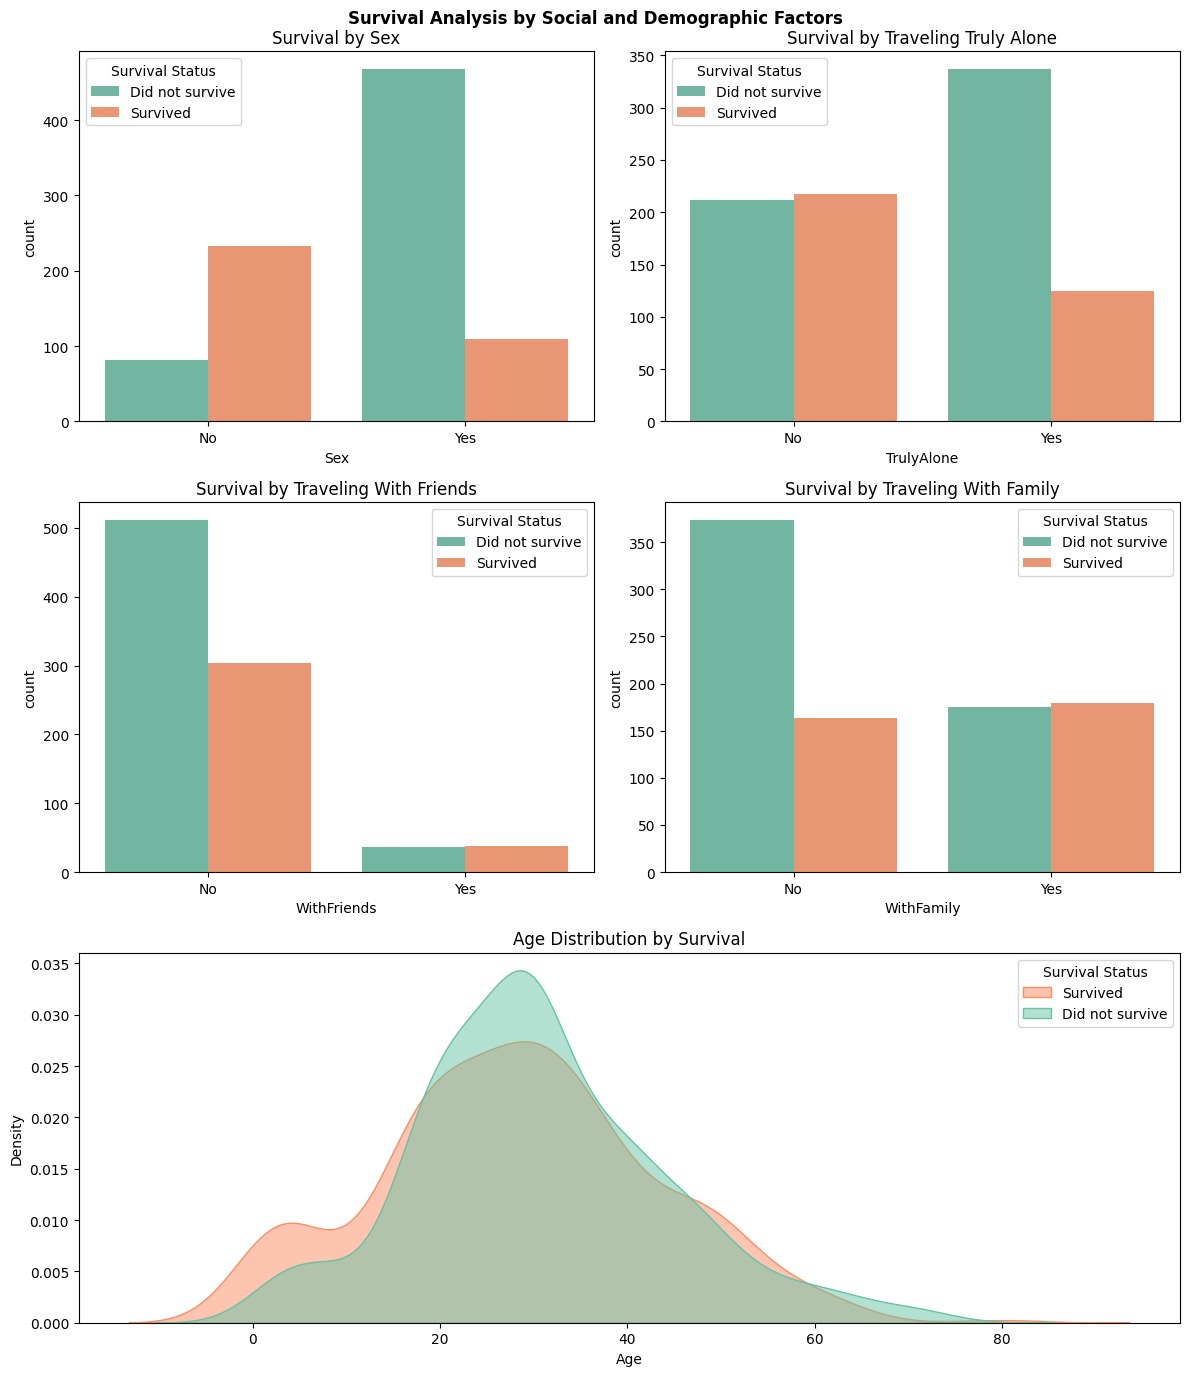

In [561]:
palette = "Set2"

fig = plt.figure(figsize=(12, 14))
fig.suptitle("Survival Analysis by Social and Demographic Factors", fontweight="bold")

ax1 = plt.subplot2grid((3, 2), (0, 0))
sns.countplot(x="Sex", hue="Survived", data=df, ax=ax1, palette=palette)
ax1.set_title("Survival by Sex")
ax1.set_xticks([0, 1])
ax1.set_xticklabels(["No", "Yes"])
ax1.legend(title="Survival Status", labels=["Did not survive", "Survived"])

ax2 = plt.subplot2grid((3, 2), (0, 1))
sns.countplot(x="TrulyAlone", hue="Survived", data=df, ax=ax2, palette=palette)
ax2.set_title("Survival by Traveling Truly Alone")
ax2.set_xticks([0, 1])
ax2.set_xticklabels(["No", "Yes"])
ax2.legend(title="Survival Status", labels=["Did not survive", "Survived"])

ax3 = plt.subplot2grid((3, 2), (1, 0))
sns.countplot(x="WithFriends", hue="Survived", data=df, ax=ax3, palette=palette)
ax3.set_title("Survival by Traveling With Friends")
ax3.set_xticks([0, 1])
ax3.set_xticklabels(["No", "Yes"])
ax3.legend(title="Survival Status", labels=["Did not survive", "Survived"])

ax4 = plt.subplot2grid((3, 2), (1, 1))
sns.countplot(x="WithFamily", hue="Survived", data=df, ax=ax4, palette=palette)
ax4.set_title("Survival by Traveling With Family")
ax4.set_xticks([0, 1])
ax4.set_xticklabels(["No", "Yes"])
ax4.legend(title="Survival Status", labels=["Did not survive", "Survived"])

ax5 = plt.subplot2grid((3, 2), (2, 0), colspan=2)
sns.kdeplot(
    df.loc[df["Survived"] == 1, "Age"].dropna(),
    label="Survived",
    ax=ax5,
    fill=True,
    alpha=0.5,
    color=sns.color_palette(palette)[1],
)
sns.kdeplot(
    df.loc[df["Survived"] == 0, "Age"].dropna(),
    label="Did not survive",
    ax=ax5,
    fill=True,
    alpha=0.5,
    color=sns.color_palette(palette)[0],
)
ax5.set_title("Age Distribution by Survival")
ax5.legend(title="Survival Status")

plt.tight_layout()
plt.show()

## 🧪 Model Training: Classification

In [562]:
features = [
    "Pclass",
    "Sex",
    "Age",
    "RelativesOnBoard",
    "WithFamily",  # Remove
    "WithFriends",
    "TrulyAlone",
    "Embarked",
    "Title",
]

X = df[features]
y = df["Survived"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [563]:
model = XGBClassifier(
    learning_rate=0.65, n_estimators=100, max_depth=3, random_state=42
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

Accuracy:  0.854749
Precision: 0.854348
Recall:    0.854749
F1 Score:  0.854439


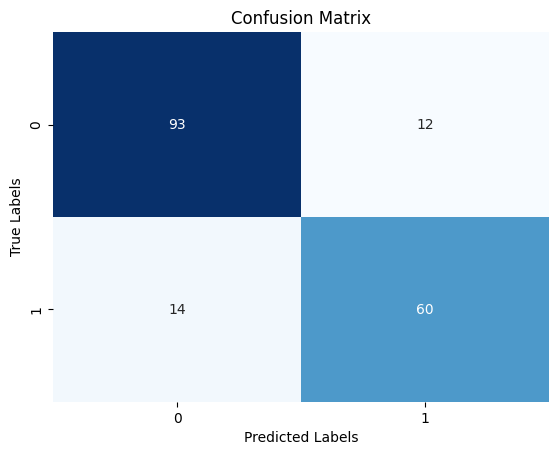

In [564]:
_ = evaluate_classification(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred)

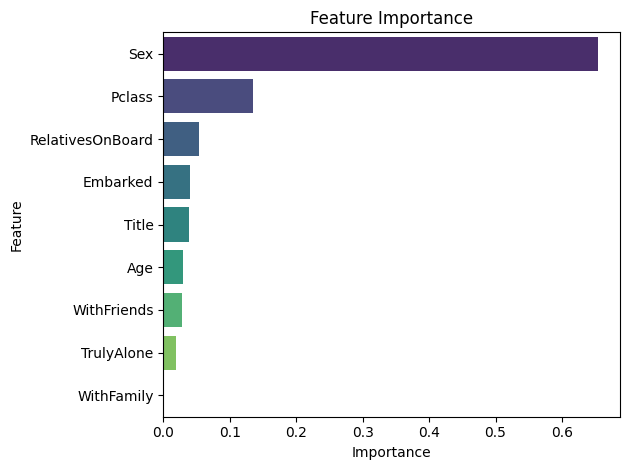

In [565]:
importances = model.feature_importances_
feature_names = X.columns

feature_importance_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": importances}
).sort_values(by="Importance", ascending=False)

sns.barplot(
    data=feature_importance_df,
    x="Importance",
    y="Feature",
    hue="Feature",
    palette="viridis",
)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

The **XGBoost model** identified `Sex`, `Pclass`, `RelativesOnBoard`, and `Embarked` as the most influential factors for survival. Meanwhile, the `WithFamily` feature shows almost zero importance, suggesting redundancy or strong correlation with other variables. Removing it could simplify the model and enhance interpretability.

### 📌 Final Classification Model Results

We successfully built an **XGBoost** survival classifier using an extended feature set, including demographics, social ties, and passenger status. The model achieves high accuracy and balanced classification metrics, confirmed by confusion matrix analysis.

🔍 **Next ideas:**
- Try cross-validation for more robust performance estimation.
- Tune hyperparameters (learning rate, depth, estimators).
- Apply SHAP or LIME for explainable AI insights.